In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
end_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Get last 12 months of data using end_date
past_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
rainfall = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > past_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rainfall_df = pd.DataFrame(rainfall)
rainfall_df = rainfall_df.fillna(0)
rainfall_df.set_index('date').head()

# Sort the dataframe by date
rainfall_df.sort_values(by='date').head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,0.00
4,2016-08-24,1.22


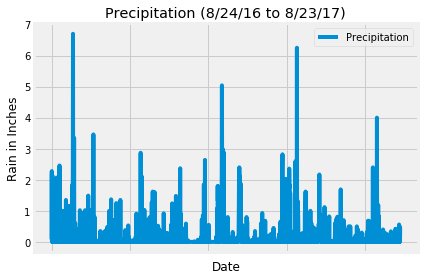

In [9]:
# Use Pandas Plotting with Matplotlib to plot the data
rainfall_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Use Pandas to calculate the summary statistics for the precipitation data
rainfall_df.describe()

,prcp
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [11]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station).distinct().count()

print(f"There are {stations} stations in this dataset.")

There are 9 stations in this dataset.


In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
        order_by(func.count(Measurement.tobs).desc()).all()
most_active = active[0][0]

print(f"The most active Station is {most_active} with {active[0][1]} weather observations.")
print("")
print("The Station list then proceeds as follows in descending order:")
for station, count in active:
    if count == 2772: continue
    print("Station",station,"with",count, "weather observations.")


The most active Station is USC00519281 with 2772 weather observations.

The Station list then proceeds as follows in descending order:
Station USC00519397 with 2724 weather observations.
Station USC00513117 with 2709 weather observations.
Station USC00519523 with 2669 weather observations.
Station USC00516128 with 2612 weather observations.
Station USC00514830 with 2202 weather observations.
Station USC00511918 with 1979 weather observations.
Station USC00517948 with 1372 weather observations.
Station USC00518838 with 511 weather observations.


In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

most_active_min = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()
most_active_max = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()
most_active_avg = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()

print(most_active_min)
print(most_active_max)
print(most_active_avg)


[(54.0,)]
[(85.0,)]
[(71.66378066378067,)]


<function matplotlib.pyplot.show(*args, **kw)>

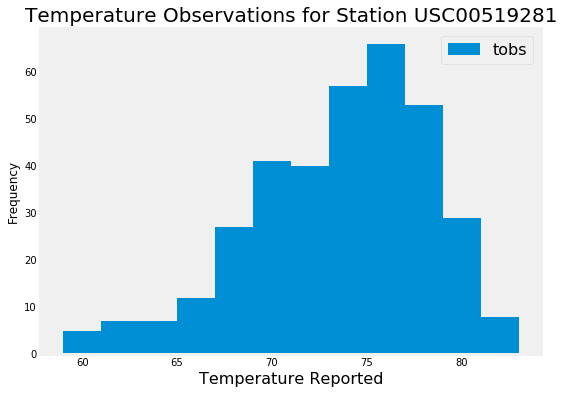

In [14]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == most_active).\
                filter(Measurement.date >= past_year).all()
temp_obs_df = pd.DataFrame(temp_obs)
temp_obs_df.set_index('station', inplace=True)

temp_obs_df.plot.hist(by='station', bins=12, figsize=(8,6))
plt.grid()
plt.title("Temperature Observations for Station " + most_active, fontsize=20)
plt.xlabel("Temperature Reported", fontsize=16)
plt.legend(bbox_to_anchor=(1,1), fontsize=16)
plt.savefig("Images/Station USC00519281 Temperatures.png")
plt.show

In [15]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [16]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-08-20', '2017-08-28')
print(trip_temps)

[(76.0, 79.85714285714286, 82.0)]


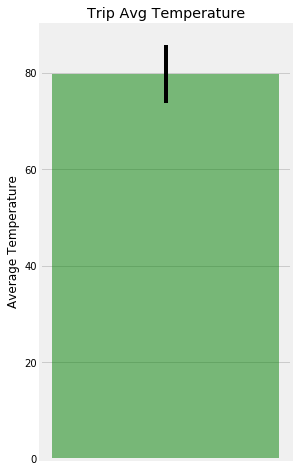

In [17]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(4,8))
plt.bar(x=0, color='green', height=trip_temps[0][1], bottom=0, alpha=0.5, align='center', yerr=(trip_temps[0][2]-trip_temps[0][0])) 
plt.title('Trip Avg Temperature')
plt.xticks([])
plt.ylabel('Average Temperature')
plt.savefig("Images/TripAvgTemp.png")


In [18]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
Rainfall = func.avg(Measurement.prcp).label("Rainfall")
rainfall_stats = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.avg(Measurement.prcp).label("Rainfall"))
    #filter(Measurement.station == Station.station).filter(Measurement.date >= '2017-08-20').\
    #filter(Measurement.date <= '2017-08-28').group_by(Measurement.station).order_by(Rainfall.desc())

index = 0
for rf in rainfall_stats:
    print(rainfall_stats[index])
    index = index + 1

('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.16064353974478685)
